In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
import itertools
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v0')

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 10000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        gamma=1.,
        mb_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [4]:
#learning   
l = 1.
step = 1000000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [30]:
#a.load_weights('../saved_agent/linear_init.h5')
a.actor.load_weights('../saved_agent/mb_self.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, episode_time=5.)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 142s 14ms/step - reward: 0.9208
1666 episodes - episode_reward: 5.525 [3.850, 5.971] - loss: 2.132 - mean_squared_error: 4.263 - mean_q: 5.609

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 148s 15ms/step - reward: 0.8765
1667 episodes - episode_reward: 5.259 [2.180, 5.816] - loss: 2.490 - mean_squared_error: 4.979 - mean_q: 5.971

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 147s 15ms/step - reward: 0.8970
1667 episodes - episode_reward: 5.382 [3.176, 5.980] - loss: 2.332 - mean_squared_error: 4.663 - mean_q: 5.855

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 171s 17ms/step - reward: 0.8220
1666 episodes - episode_reward: 4.932 [2.938, 5.800] - loss: 2.628 - mean_squared_error: 5.256 - mean_q: 6.025

Interval 5 (40000 steps performed)
10000/10000 [=====================

(6, 2)
(6, 2)
(6, 2)
(6, 2)
(6, 2)
(6, 2)
(6, 2)
(6, 2)
(6, 2)
(4, 2)


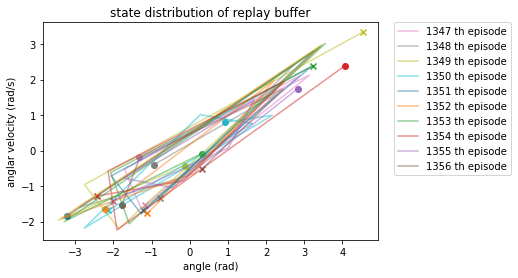

In [6]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, em in enumerate(a.state_memory):
    if i<len(a.state_memory)-10:
        continue
    print(em.shape)
    plt.scatter(em[0,0], em[0,1], marker='o', color=cycle[i % 10])
    plt.scatter(em[-1,0], em[-1,1], marker='x', color=cycle[i % 10])
    plt.plot(em[:,0], em[:,1], color=cycle[i % 10], label=f'{i+1} th episode', alpha=0.5)
plt.xlabel('angle (rad)')
plt.ylabel('anglar velocity (rad/s)')
plt.title('state distribution of replay buffer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.xlim(-10, 10)
plt.show()

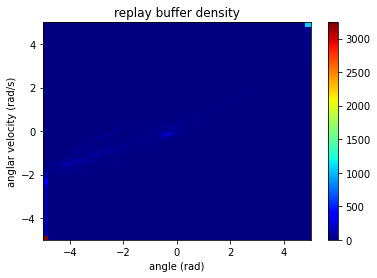

In [7]:
memory = np.array(list(itertools.chain.from_iterable(np.array(a.state_memory))))
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
fig = plt.figure()
ax = fig.add_subplot(111)
replay_buffer = memory
H = ax.hist2d(replay_buffer[:,0], replay_buffer[:,1], bins=50, cmap=cm.jet)
# H[3].set_clim(0,200)
fig.colorbar(H[3],ax=ax)
ax.set_title('replay buffer density')
ax.set_xlabel('angle (rad)')
ax.set_ylabel('anglar velocity (rad/s)')
plt.show()

In [31]:
env.reset()
a.training = False
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = a.forward(x)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(a.forward(env.state)[0])
states = np.array(states)
detail_states = np.array(detail_states)

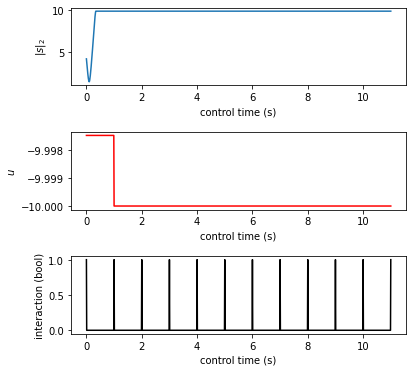

In [32]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [52]:
a.save_weights('../saved_agent/learned_self_linear0.h5')

In [6]:
def gain(A, B, Q, R, dt=None):
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K


def make_standup_agent2(actor_net, tau, env, epochs=100, verbose=False):
    # 学習データの用意
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    K = gain(env.A, env.B.reshape(2,1), .01*np.eye(2), np.array([[.01]]), dt)
    print(K)
    x_train = []
    y_train = []
    high = np.array([np.pi, np.pi])
    for i in range(30000):
        x_train.append([np.random.uniform(low=-high, high=high)])
        y_train.append([np.dot(K, x_train[-1][0]), tau])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # 学習
    actor_net.compile(loss='mean_squared_error',optimizer='adam')
    actor_net.fit(x_train, y_train, batch_size=128, epochs=epochs, verbose=verbose)

    return actor_net

In [7]:
make_standup_agent2(a.actor, 0.01, env, verbose=True)

[-0.95089361 -0.91851593]
Epoch 1/100
30000/30000 [==============================] - 1s 36us/step - loss: 2.6428
Epoch 2/100
30000/30000 [==============================] - 0s 16us/step - loss: 0.4169
Epoch 3/100
30000/30000 [==============================] - 0s 16us/step - loss: 0.2493
Epoch 4/100
30000/30000 [==============================] - 0s 15us/step - loss: 0.1328
Epoch 5/100
30000/30000 [==============================] - 0s 16us/step - loss: 0.0600
Epoch 6/100
30000/30000 [==============================] - 0s 16us/step - loss: 0.0345
Epoch 7/100
30000/30000 [==============================] - 0s 16us/step - loss: 0.0216
Epoch 8/100
30000/30000 [==============================] - 0s 15us/step - loss: 0.0132
Epoch 9/100
30000/30000 [==============================] - 0s 15us/step - loss: 0.0086
Epoch 10/100
30000/30000 [==============================] - 1s 25us/step - loss: 0.0060
Epoch 11/100
30000/30000 [==============================] - 0s 17us/step - loss: 0.0045
Epoch 12/100
30

KeyboardInterrupt: 

In [8]:
a.save_weights('../saved_agent/linear_init.h5')

[WARNING] ../saved_agent/linear_init_actor.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
[WARNING] ../saved_agent/linear_init_critic.h5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


In [9]:
x = np.array([2,1])
a.forward(x)

array([-2.85683823,  0.01100095])

In [7]:
K = np.array([-0.95089361, -0.91851593])
np.dot(K,x)

-2.82030315

In [12]:
Ad, Bd = discretized_system(env.A, env.B, dt)

x = np.array([2,1])
for i in range(1000):
    u = np.dot(K, x)
    print(x, u)
    x = np.dot(Ad, x) + np.dot(Bd, u)

[2 1] -2.82030315
[1.93410287 0.81390397] -2.5867098266754063
[1.86438108 0.65244044] -2.3721050009502243
[1.79199991 0.51275856] -2.1749781659030685
[1.7179518  0.39231381] -1.9939358743976334
[1.64307747 0.28883669] -1.827692964261768
[1.56808461 0.2003044 ] -1.675064412016747
[1.49356455 0.1249154 ] -1.5349577731037618
[1.42000703 0.06106651] -1.4063661690520362
[1.3478133  0.00733218] -1.2883617844180544
[ 1.27730773 -0.03755397] -1.1800898385986345
[ 1.20874806 -0.07471597] -1.080762999783156
[ 1.1423345  -0.10515045] -0.9896562103640173
[ 1.0782177  -0.12974018] -0.9061018950717371
[ 1.01650587 -0.14926623] -0.8294855249448225
[ 0.95727092 -0.16441881] -0.759241511987694
[ 0.900554   -0.17580711] -0.6948494110159784
[ 0.84637022 -0.1839681 ] -0.6358304067409097
[ 0.79471288 -0.18937433] -0.5817440656070617
[ 0.74555714 -0.19244106] -0.5321853332739609
[ 0.69886318 -0.1935326 ] -0.4867817599260553
[ 0.65457905 -0.19296791] -0.445190936810849
[ 0.61264301 -0.19102575] -0.4070981285

[-1.89579098e-17  2.07406354e-17] -1.0236487704916529e-18
[-1.71501466e-17  1.88539688e-17] -1.0097058253896248e-18
[-1.55111994e-17  1.71362041e-17] -9.903760525056666e-19
[-1.40255886e-17  1.55724485e-17] -9.666994336334886e-19
[-1.26792307e-17  1.41491027e-17] -9.395767571916745e-19
[-1.14593144e-17  1.28537506e-17] -9.097858163623782e-19
[-1.03541874e-17  1.16750578e-17] -8.779958607368176e-19
[-9.35325321e-18  1.06026786e-17] -8.447804807022095e-19
[-8.44687684e-18  9.62717141e-18] -8.106290860521729e-19
[-7.62629912e-18  8.73992052e-18] -7.759571242608372e-19
[-6.88355824e-18  7.93306515e-18] -7.4111516936852595e-19
[-6.21141833e-18  7.19943420e-18] -7.063969993377485e-19
[-5.60330433e-18  6.53248665e-18] -6.720467679195916e-19
[-5.05324261e-18  5.92625701e-18] -6.382653664019296e-19
[-4.55580686e-18  5.37530546e-18] -6.052160609831122e-19
[-4.10606877e-18  4.87467217e-18] -5.730294828286623e-19
[-3.69955305e-18  4.41983558e-18] -5.418080400343701e-19
[-3.33219649e-18  4.00667429

[ 3.22831647e-27 -3.23634129e-27] -9.715447505174977e-29
[ 2.93204616e-27 -2.95076756e-27] -7.773695555975201e-29
[ 2.66251767e-27 -2.69002044e-27] -6.094441324889745e-29
[ 2.41735443e-27 -2.45197379e-27] -4.6469889347782054e-29
[ 2.19438791e-27 -2.23468071e-27] -3.4039618930643494e-29
[ 1.99163975e-27 -2.03635869e-27] -2.3409617501572528e-29
[ 1.80730525e-27 -1.85537600e-27] -1.4362606175942142e-29
[ 1.63973840e-27 -1.69023909e-27] -6.705242791830675e-30
[ 1.48743812e-27 -1.53958111e-27] -2.656293651739633e-31
[ 1.34903568e-27 -1.40215134e-27] 5.10893090167027e-30
[ 1.22328321e-27 -1.27680545e-27] 9.553951311367405e-30
[ 1.10904319e-27 -1.16249662e-27] 1.318957601508027e-29
[ 1.00527883e-27 -1.05826736e-27] 1.6122210872606966e-29
[ 9.11045272e-28 -9.63241995e-28] 1.8445988800872543e-29
[ 8.25481582e-28 -8.76619796e-28] 2.0244085866207475e-29
[ 7.47803390e-28 -7.97668656e-28] 2.1589902820046646e-29
[ 6.77296189e-28 -7.25719306e-28] 2.2548125367637208e-29
[ 6.13309201e-28 -6.60159999e-2

In [16]:
x = np.array([2,1])
env.set_state(x)
for i in range(1000):
    u,_ = a.forward(x)
    print(x, u)
    _,_,_,_ = env.step([u], .01,.01)
    x = env.state

[2 1] -2.8568382263183594
[1.96286324 0.89572647] -2.7253177165985107
[1.92455731 0.79909923] -2.598820686340332
[1.88529929 0.70966457] -2.477294445037842
[1.84528699 0.62698885] -2.360668897628784
[1.8047003  0.55065816] -2.248854160308838
[1.76370254 0.48027826] -2.141746759414673
[1.72244171 0.41547409] -2.039233684539795
[1.68105158 0.35588936] -1.9411892890930176
[1.63965285 0.30118613] -1.8474830389022827
[1.59835411 0.25104429] -1.757979154586792
[1.55725276 0.20516087] -1.6725367307662964
[1.51643593 0.16324963] -1.5910155773162842
[1.47598124 0.12504024] -1.5132712125778198
[1.43595762 0.09027781] -1.439159870147705
[1.39642596 0.05872223] -1.368540644645691
[1.35743977 0.03014746] -1.3012733459472656
[1.31904581 0.0043409 ] -1.2372183799743652
[ 1.28128462 -0.01889715] -1.17776358127594
[ 1.24416061 -0.03981509] -1.122607946395874
[ 1.20767424 -0.05864174] -1.0698732137680054
[ 1.17185437 -0.07552393] -1.0194698572158813
[ 1.13672547 -0.09059992] -0.9713074564933777
[ 1.1023

[-0.06675196 -0.022323  ] 0.01726863905787468
[-0.06663199 -0.0222976 ] 0.017196815460920334
[-0.06651363 -0.02227344] 0.01712573692202568
[-0.06639692 -0.02225048] 0.017055554315447807
[-0.06628186 -0.02222869] 0.016986114904284477
[-0.06616847 -0.02220802] 0.0169172715395689
[-0.06605676 -0.02218846] 0.016849620267748833
[-0.06594674 -0.02216995] 0.016782565042376518
[-0.06583842 -0.02215249] 0.016716105863451958
[-0.06573181 -0.02213603] 0.016650987789034843
[-0.06562691 -0.02212055] 0.01658676378428936
[-0.06552373 -0.022106  ] 0.016523286700248718
[-0.06542227 -0.02209236] 0.016460701823234558
[-0.06532252 -0.02207961] 0.01639886200428009
[-0.06522451 -0.02206772] 0.01633821427822113
[-0.06512821 -0.02205665] 0.016278311610221863
[-0.06503362 -0.02204638] 0.016219452023506165
[-0.06494075 -0.02203688] 0.016161484643816948
[-0.06484959 -0.02202813] 0.016104266047477722
[-0.06476014 -0.02202011] 0.016048237681388855
[-0.06467237 -0.02201278] 0.01599280722439289
[-0.06458631 -0.02200

[-0.06184349 -0.02251284] 0.014034797437489033
[-0.06184487 -0.02251294] 0.014035691507160664
[-0.06184623 -0.02251302] 0.014036585576832294
[-0.06184756 -0.02251309] 0.014037180691957474
[-0.06184886 -0.02251316] 0.01403807569295168
[-0.06185014 -0.02251322] 0.014039118774235249
[-0.06185138 -0.02251326] 0.014039713889360428
[-0.0618526 -0.0225133] 0.014040459878742695
[-0.0618538  -0.02251334] 0.014041055925190449
[-0.06185497 -0.02251337] 0.014042248018085957
[-0.06185611 -0.02251338] 0.014042546041309834
[-0.06185724 -0.0225134 ] 0.014043589122593403
[-0.06185833 -0.0225134 ] 0.014044334180653095
[-0.0618594  -0.02251339] 0.014045227319002151
[-0.06186043 -0.02251336] 0.01404582429677248
[-0.06186145 -0.02251334] 0.014046122319996357
[-0.06186244 -0.02251332] 0.014047016389667988
[-0.06186341 -0.02251329] 0.014047612436115742
[-0.06186436 -0.02251326] 0.014048207551240921
[-0.06186528 -0.02251322] 0.014049102552235126
[-0.06186617 -0.02251316] 0.014049400575459003
[-0.06186705 -0.0

[-0.06188745 -0.02250433] 0.014065493829548359
[-0.06188744 -0.02250433] 0.014065493829548359
[-0.06188743 -0.02250433] 0.014065493829548359
[-0.06188742 -0.02250433] 0.014065493829548359
[-0.06188741 -0.02250433] 0.014065493829548359
[-0.0618874  -0.02250433] 0.014065493829548359
[-0.06188739 -0.02250432] 0.014065642841160297
[-0.06188737 -0.02250432] 0.014065493829548359
[-0.06188736 -0.02250432] 0.014065493829548359
[-0.06188735 -0.02250431] 0.014065493829548359
[-0.06188734 -0.02250431] 0.014065194875001907
[-0.06188734 -0.02250432] 0.014065493829548359
[-0.06188733 -0.02250432] 0.014065493829548359
[-0.06188731 -0.02250432] 0.014065194875001907
[-0.06188731 -0.02250432] 0.014065493829548359
[-0.0618873  -0.02250432] 0.014065194875001907
[-0.0618873  -0.02250433] 0.014065493829548359
[-0.06188729 -0.02250433] 0.014065493829548359
[-0.06188728 -0.02250432] 0.014065194875001907
[-0.06188727 -0.02250433] 0.014065493829548359
[-0.06188726 -0.02250433] 0.014065194875001907
[-0.06188726 

[-0.06188735 -0.02250444] 0.01406534481793642
[-0.06188735 -0.02250444] 0.01406534481793642
[-0.06188735 -0.02250444] 0.01406534481793642
[-0.06188734 -0.02250444] 0.01406534481793642
[-0.06188734 -0.02250444] 0.01406534481793642
[-0.06188734 -0.02250444] 0.01406534481793642
[-0.06188734 -0.02250444] 0.01406534481793642
[-0.06188733 -0.02250444] 0.01406534481793642
[-0.06188733 -0.02250444] 0.01406534481793642
[-0.06188733 -0.02250444] 0.01406534481793642
[-0.06188732 -0.02250444] 0.01406534481793642
[-0.06188732 -0.02250444] 0.01406534481793642
[-0.06188732 -0.02250444] 0.01406534481793642
[-0.06188732 -0.02250444] 0.01406534481793642
[-0.06188731 -0.02250444] 0.01406534481793642
[-0.06188731 -0.02250444] 0.01406534481793642
[-0.06188731 -0.02250444] 0.01406534481793642
[-0.06188731 -0.02250444] 0.014065194875001907
[-0.06188731 -0.02250444] 0.01406534481793642
[-0.06188731 -0.02250444] 0.01406534481793642
[-0.0618873  -0.02250444] 0.01406534481793642
[-0.0618873  -0.02250444] 0.01406

In [54]:
x, np.clip(x,0,1)

(array([ 0.67276703, -0.56438167]), array([0.67276703, 0.        ]))

In [31]:
pow(.99,3)

0.970299